Thursday, June 15, 2023

docker container start sad_nightingale

[Building makemore Part 5: Building a WaveNet](https://www.youtube.com/watch?v=t3YJ5hKiMQ0)

[WaveNet: A Generative Model for Raw Audio](https://arxiv.org/abs/1609.03499)

In [ ]:
# GPU
# Run Date: Saturday, June 17, 2023
# Run Time: 00:28:44

In [1]:
import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
useGPU = True
if torch.cuda.is_available() and useGPU:
    device = torch.device("cuda")  # Use GPU
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    device = torch.device("cpu")  # Fallback to CPU if GPU is not available
device

device(type='cuda')

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
lenOfWords = len(words)
print(lenOfWords)
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
delimiter = '.'
stoi = {c:i+1 for i,c in enumerate(chars)}
stoi[delimiter] = 0
itos = { c:i for i, c in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + delimiter:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [7]:
thgttg = 42
manualSeed = 2147483647

In [8]:
import random
random.seed(thgttg)
random.shuffle(words)

n1 = int(0.8 * lenOfWords)
n2 = int(0.9 * lenOfWords)
print(n1, n2)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

25626 28829
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [10]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [11]:
torch.manual_seed(42)

In [12]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))

layers = [
    
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
]

In [13]:
# parameter initialization
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

In [14]:
parameters = [C] + [p for layer in  layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

12097


In [15]:
for p in parameters:
    p.requires_grad = True

#### Training Loop 1

In [16]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # 1) minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # 2) forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # 3) backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # 4) update using simple stochastic gradient descent
    lr = 0.1 if i < 150000 else 0.01 # step learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # 5) track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

# CPU
# CPU times: user 20min 25s, sys: 2.89 s, total: 20min 27s
# Wall time: 2min 44s
# CPU times: user 20min 44s, sys: 2.3 s, total: 20min 47s
# Wall time: 2min 48s

# GPU
# CPU times: user 2min 47s, sys: 1.85 s, total: 2min 49s
# Wall time: 3min
# CPU times: user 2min 44s, sys: 1.87 s, total: 2min 46s
# Wall time: 2min 57s
# CPU times: user 2min 44s, sys: 1.73 s, total: 2min 45s
# Wall time: 2min 57s

      0/ 200000: 3.3078
  10000/ 200000: 2.5182
  20000/ 200000: 2.3602
  30000/ 200000: 2.1772
  40000/ 200000: 1.7950
  50000/ 200000: 2.0970
  60000/ 200000: 2.4589
  70000/ 200000: 2.3914
  80000/ 200000: 2.1428
  90000/ 200000: 1.9203
 100000/ 200000: 2.4530
 110000/ 200000: 2.0541
 120000/ 200000: 2.1013
 130000/ 200000: 1.8963
 140000/ 200000: 2.0727
 150000/ 200000: 2.1303
 160000/ 200000: 2.6925
 170000/ 200000: 2.6305
 180000/ 200000: 2.0180
 190000/ 200000: 2.0573
CPU times: user 2min 47s, sys: 1.85 s, total: 2min 49s
Wall time: 3min


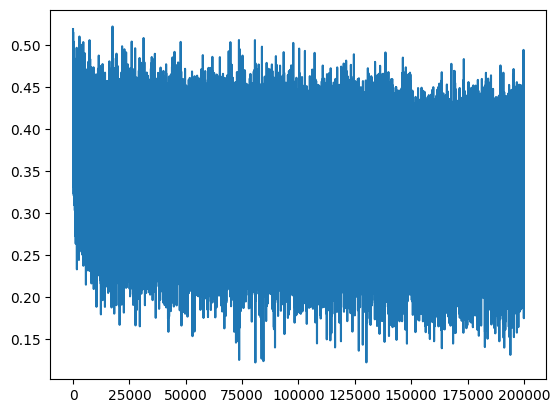

In [17]:
plt.plot(lossi)

In [18]:
# put layers into eval mode (needed for batchnorm especially)
# notice as of right now this only applys to BatchNorn1d
for layer in layers:
    layer.training = False

#### Evaluate the Loss 1

In [19]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

In [20]:
split_loss('train')
split_loss('val')

train 2.059004068374634
val 2.1056885719299316


#### Sample from the model 1

In [21]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:

        # forward pass the neural net
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, then break
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # decode and print the generated word

ire.
takayler.
arnalim.
bhon.
yurindley.
per.
terrioleigh.
deugio.
her.
anaiyi.
jashden.
jinnon.
sivi.
semari.
cheem.
lison.
dia.
morgi.
alah.
elda.


#### Let's fix the learning rate plot

In [22]:
torch.tensor(lossi).view(-1, 1000).shape

torch.Size([200, 1000])

Each row is 1000 consecutive elements in the lossi list. 

We can take the mean of each row, and we can then plot that:

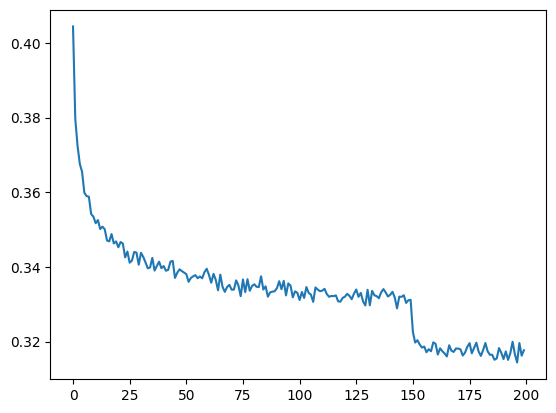

In [23]:
# notice we have to copy the tensor to the cpu
plt.plot(torch.tensor(lossi).cpu().view(-1, 1000).mean(dim=1))

#### PyTorch-ifying our code

Right now our embedding layer is not part of our stack of layers and neither is the concatenation of the tensor. Let's fix that.

![](images/part5_cnn_emb.png)

In [24]:
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
        
    def parameters(self):
        return [self.weight]

In [25]:
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

So now we can add these 2 new layers to our layers collection and take out C.

In [26]:
# our new layers collection
layers = [

    Embedding(vocab_size, n_embd),
    Flatten(),
    
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
]

Our parameters collection no longer needs C, so let's redefine it.

In [27]:
parameters = [p for layer in  layers for p in layer.parameters()]

for p in parameters:
    p.requires_grad = True
    
print(sum(p.nelement() for p in parameters))

12097


#### Training Loop 2

We need a new training loop.

In [28]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # 1) minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # 2) forward pass ... the only changes from Training Loop 1
    # emb = C[Xb] # embed the characters into vectors
    # x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # for layer in layers:
    #     x = layer(x)
    x = Xb
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # 3) backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # 4) update using simple stochastic gradient descent
    lr = 0.1 if i < 150000 else 0.01 # step learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # 5) track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # let's break after the first pass ...
    break

      0/ 200000: 3.6120
CPU times: user 3.87 ms, sys: 0 ns, total: 3.87 ms
Wall time: 3.39 ms


Right now, layers is a simple list. PyTorch has a container for neural network layers (or modules) called [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)

Let's implement our own simpler version of Sequential.

In [29]:
class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and strech them out into one list
        return [p for layer in self.layers for p in layer.parameters()]
    

So now we no longer need out naked list of layers. We can add the layers to our Sequential collection and create a model object.

In [30]:
model = Sequential([

    Embedding(vocab_size, n_embd),
    Flatten(),
    
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
])

We can now just assign model.parameters() to parameters.

In [31]:
# parameters = [p for layer in  layers for p in layer.parameters()]
parameters = model.parameters()
for p in parameters:
    p.requires_grad = True
    
print(sum(p.nelement() for p in parameters))

12097


#### Training Loop 3

Yup, redefine ... but this time actually train the model.

In [32]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # 1) minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # 2) Forward pass
    # x = Xb
    # for layer in layers:
    #     x = layer(x)
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # 3) backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # 4) update using simple stochastic gradient descent
    lr = 0.1 if i < 150000 else 0.01 # step learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # 5) track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

# CPU
# CPU times: user 18min 56s, sys: 2.69 s, total: 18min 59s
# Wall time: 2min 30s
# CPU times: user 18min 46s, sys: 1.82 s, total: 18min 48s
# Wall time: 2min 28s

# GPU
# CPU times: user 2min 47s, sys: 1.8 s, total: 2min 49s
# Wall time: 3min 1s
# CPU times: user 2min 45s, sys: 1.67 s, total: 2min 47s
# Wall time: 2min 58s
# CPU times: user 2min 44s, sys: 1.85 s, total: 2min 46s
# Wall time: 2min 57s

      0/ 200000: 3.4704
  10000/ 200000: 2.2268
  20000/ 200000: 1.9324
  30000/ 200000: 2.2441
  40000/ 200000: 2.2577
  50000/ 200000: 1.7740
  60000/ 200000: 1.9609
  70000/ 200000: 1.8011
  80000/ 200000: 2.3215
  90000/ 200000: 2.2641
 100000/ 200000: 1.8790
 110000/ 200000: 1.9008
 120000/ 200000: 2.0905
 130000/ 200000: 2.4779
 140000/ 200000: 1.8521
 150000/ 200000: 2.2732
 160000/ 200000: 2.2655
 170000/ 200000: 2.1052
 180000/ 200000: 2.0711
 190000/ 200000: 2.3293
CPU times: user 2min 47s, sys: 1.8 s, total: 2min 49s
Wall time: 3min 1s


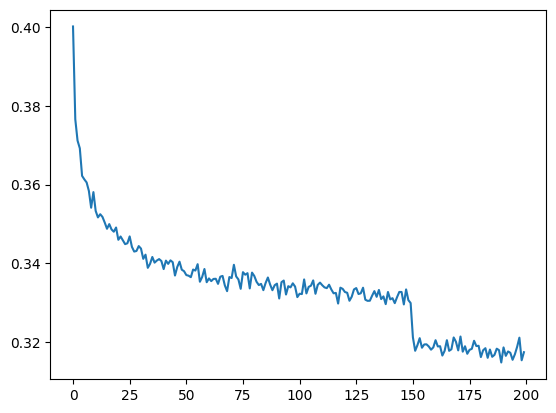

In [33]:
# notice we have to copy the tensor to the cpu
plt.plot(torch.tensor(lossi).cpu().view(-1, 1000).mean(dim=1))

In [34]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

#### Evaluate the Loss 2

In [35]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    # emb = C[x] # (N, block_size, n_embd)
    # x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    # for layer in layers:
    #     x = layer(x)
    logits = model(x)
    # loss = F.cross_entropy(x, y)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [36]:
split_loss('train')
split_loss('val')

train 2.0583231449127197
val 2.106529951095581


#### Sample from the model 2

In [37]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:

        # forward pass the neural net
        # emb = C[torch.tensor([context])]
        # x = emb.view(emb.shape[0], -1) # concatenate the vectors
        # for layer in layers:
        #     x = layer(x)
        # logits = x
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, then break
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # decode and print the generated word

akshey.
ailyn.
akalaino.
jussani.
amar.
mira.
aad.
chriyah.
elldi.
dhalon.
fyldanie.
malexxany.
crevhan.
aizahluva.
kaylyn.
avyn.
ais.
hamara.
candaliel.
katisie.


## WaveNet

First thing we want to do is to rebuild our dataset with a larger block size of 8:

In [38]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + delimiter:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [39]:
n1 = int(0.8 * lenOfWords)
n2 = int(0.9 * lenOfWords)
print(n1, n2)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

25626 28829
torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [40]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [41]:
torch.manual_seed(42)

In [42]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([

    Embedding(vocab_size, n_embd),
    Flatten(),
    
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22097


#### Training Loop 4

In [43]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # 1) minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # 2) Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # 3) backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # 4) update using simple stochastic gradient descent
    lr = 0.1 if i < 150000 else 0.01 # step learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # 5) track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

# CPU
# CPU times: user 18min 59s, sys: 2.88 s, total: 19min 2s
# Wall time: 2min 29s
# CPU times: user 20min 5s, sys: 2.08 s, total: 20min 7s
# Wall time: 2min 40s

# GPU
# CPU times: user 2min 47s, sys: 1.67 s, total: 2min 48s
# Wall time: 3min
# CPU times: user 2min 46s, sys: 1.65 s, total: 2min 48s
# Wall time: 2min 59s
# CPU times: user 2min 45s, sys: 1.93 s, total: 2min 47s
# Wall time: 2min 58

      0/ 200000: 3.3126
  10000/ 200000: 2.4891
  20000/ 200000: 2.3465
  30000/ 200000: 2.1099
  40000/ 200000: 1.6623
  50000/ 200000: 2.0117
  60000/ 200000: 2.3529
  70000/ 200000: 2.3503
  80000/ 200000: 1.9445
  90000/ 200000: 1.7863
 100000/ 200000: 2.2284
 110000/ 200000: 2.0006
 120000/ 200000: 1.9971
 130000/ 200000: 1.8105
 140000/ 200000: 1.9407
 150000/ 200000: 1.9409
 160000/ 200000: 2.3154
 170000/ 200000: 2.5088
 180000/ 200000: 1.9036
 190000/ 200000: 2.0041
CPU times: user 2min 47s, sys: 1.67 s, total: 2min 48s
Wall time: 3min


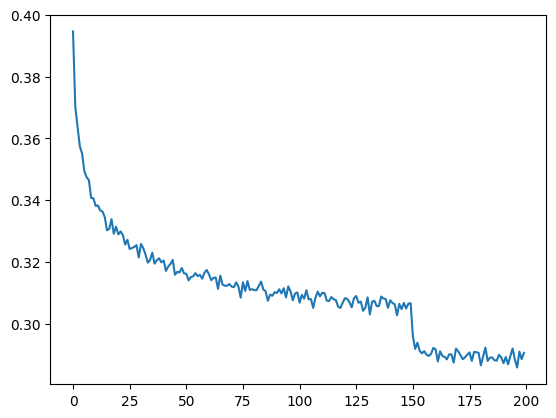

In [44]:
# notice we have to copy the tensor to the cpu
plt.plot(torch.tensor(lossi).cpu().view(-1, 1000).mean(dim=1))

In [45]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [46]:
# using Evaluate the Loss 2 ... 
split_loss('train')
split_loss('val')

train 1.9189682006835938
val 2.033379554748535


#### Sample from the model 2 (copied from a previous cell)

In [47]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:

        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, then break
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # decode and print the generated word

irel.
adayah.
aarell.
maxzos.
yuqanda.
mylei.
terrik.
eifina.
ugionne.
kaobie.
mershdez.
jinnory.
bethse.
astyn.
jammii.
omenia.
morgereta.
penel.
taishora.
thalynx.


Notice the names appear to be better because we have an increased block_size. 

#### Implementing WaveNet

Let's do a forward pass through the model and observe the shape of the tensors through each layer.

In [48]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # Let's look at a batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  4],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0, 10,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  1]])

In [49]:
#  Embedding(vocab_size, n_embd),
# output of the Embedding layer 
model.layers[0].out.shape 

torch.Size([4, 8, 10])

For each character in our embedding table, there is a n_embd = 10 dimensional vector that we are trying to learn. Recall our block_size = 8 which means we are using the previous 8 characters to predict the next character. So what the embedding layer does is pluck out the embedding vector for each one of the integers shown above, and loads it into a 3-dimensional 4x8x10 tensor.

In [50]:
# Flatten(),
# output of the flatten layer
model.layers[1].out.shape 

torch.Size([4, 80])

Passing through the Flatten layer will stretch out the 8 characters each expressed as a 10 dimensional embedding into one long tensor of length 80.

In [51]:
#  Linear(n_embd * block_size, n_hidden, bias=False),
# output of the Linear layer
model.layers[2].out.shape 

torch.Size([4, 200])

The Linear layer takes the 80 tensor and creates a n_hidden=200 channel tensor using matrix multiplication.

![](images/LinearLayer.png)

In [52]:
# an example of what happens in the linear layer using the dimensions of our current model ...
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [53]:
# but we don't have to use a (4,80) tensor ... we could also use, say, (4, 5, 80)
(torch.randn(4, 5, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 200])

In [54]:
# or whatever ...
(torch.randn(4, 5, 20, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 20, 200])

You can see the matrix multiplication only works on the last tensor and the dimensions before it on the input tensor are left unchanged. (They are treated like a batch dimension)

In [55]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [56]:
# we can index like this to get all the even parts ...
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [57]:
# and we can index like this to get all the odd parts ...
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [58]:
# This is what Flatten currently does ...
e = torch.randn(4, 8, 10)
e.view(e.shape[0], -1).shape

torch.Size([4, 80])

In [59]:
# But we want this ... all the even characters
e[:, ::2, :]

tensor([[[ 1.8944, -0.3630, -1.6057,  0.2113,  0.4976, -1.1725,  0.7215,
           0.0033, -0.9241,  0.6180],
         [-0.0312, -0.2203,  0.1806,  0.2252,  1.3032, -0.4535,  1.4604,
          -0.3124,  0.4088,  0.4944],
         [ 0.7316,  0.7110,  1.3705, -0.1574,  2.8110, -0.0840,  0.3656,
           1.6580,  0.9855,  1.4903],
         [-0.0586,  0.9887,  1.3463, -1.8633, -2.7923,  0.5817,  0.2906,
          -1.7619,  0.3827,  0.3663]],

        [[ 1.4723, -2.1453, -0.2186,  1.5866,  1.1769, -1.5464,  0.2877,
           0.0712, -1.6581,  0.1125],
         [-1.6880,  0.8210,  0.1784, -0.4882,  1.1269, -0.8511, -0.0333,
          -0.5674,  0.2276, -0.5137],
         [-0.1710,  0.2592,  0.9084,  0.7582, -0.1840,  1.6436,  0.0233,
           0.3515, -0.7775,  0.2146],
         [-1.0549,  1.4117, -1.0050,  0.1645, -1.9776,  0.9263,  0.9257,
           2.0640, -0.1862,  0.5332]],

        [[-0.5189,  0.1490,  1.1090,  1.0187,  1.9270,  0.9732, -1.1426,
           0.1601,  1.5682, -0.4073

In [60]:
# all the odd characters
e[:,1::2,:]

tensor([[[-0.3633,  0.8599, -1.0843,  1.7660, -0.0506,  0.0304, -0.4242,
          -2.2338,  0.2270,  0.8791],
         [ 0.8978,  0.2603,  1.3761,  0.6955, -0.1637, -0.9009, -0.2614,
           0.4926, -0.1258,  0.6691],
         [-1.0338, -1.1003,  0.3031,  0.3486,  0.2790,  0.8275, -0.5953,
          -0.0741, -0.2996,  0.6982],
         [ 0.1635,  0.6974, -0.7492,  0.1831,  1.7281, -2.1709,  0.4674,
          -0.3190, -0.6221,  0.3078]],

        [[-0.1887,  1.5056, -0.8774, -0.2432, -0.7576,  0.7936,  0.7872,
          -0.0819, -0.1514, -0.3609],
         [ 1.3590,  1.2619,  1.5060,  1.3734, -0.7106, -0.2943,  0.3685,
           0.4673,  0.6192,  1.3104],
         [-1.6380,  0.7592, -0.6848,  1.1672, -0.2793, -0.4653, -1.5674,
          -0.8808, -1.0851, -2.2145],
         [ 1.2064, -0.0668, -1.1559,  0.1620, -1.7665,  0.5925, -0.8389,
          -0.8226, -0.1307,  0.3857]],

        [[ 0.3072, -1.7973,  0.4132,  0.4630,  0.8252,  0.0401,  0.3607,
           0.1984, -0.7800,  1.5354

In [61]:
# doing this will give us what we want ...
explicit = torch.cat([e[:,::2,:],e[:,1::2,:]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

Turns out you don't need to do this, you can just view it how you want to shape it. 

In [62]:
e.view(4,4,20) == explicit

tensor([[[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True]],

        [[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [T

In [63]:
# you can do this to see if all are True ... yeah, they are!
(e.view(4, 4, 20) == explicit).all()

tensor(True)

So let's redefine the Flatten layer. This code will deviate the PyTorch implementation, so let's give it a different name.

This class will only flatten some n consecutive elements and puts them into the last dimension.

In [64]:
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

And now we can redefine out model with this new layer.

In [65]:
model = Sequential([

    Embedding(vocab_size, n_embd),
    FlattenConsecutive(block_size), 
    
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
])

In [66]:
# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22097


In [67]:
# run our previous example ...
ix = torch.randint(0, Xtr.shape[0], (4,)) # Let's look at a batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0, 10,  5, 25,  4,  5],
        [ 0,  0,  1, 18, 14,  5, 12, 12],
        [ 0,  0,  0,  0,  0, 13,  5, 14],
        [ 0,  0,  8,  1,  2,  5,  5,  2]])

In [68]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


So here is our first attempt at a WaveNet like model:

In [69]:
model = Sequential([

    Embedding(vocab_size, n_embd),
    
    FlattenConsecutive(2),  Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),

    Linear(n_hidden, vocab_size)
])

In [70]:
# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

170897


In [71]:
# run our previous example ...
ix = torch.randint(0, Xtr.shape[0], (4,)) # Let's look at a batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 5, 13,  9, 14,  7, 20, 15, 14],
        [ 0,  0,  2, 15,  3,  5, 16,  8],
        [ 0,  0,  0, 14,  1, 22, 18,  1],
        [ 0,  0,  0,  0,  0,  0, 18, 15]])

In [72]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


![](images/WaveNet.png)

Our model conforms to the WaveNet model. Nice!

In the Karpathy video, he makes some tweaks to the model parameters:

In [73]:
n_embd = 10
n_hidden = 68

model = Sequential([

    Embedding(vocab_size, n_embd),
    
    FlattenConsecutive(2),  Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),

    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22397


So let's try to train this and see what we now get!

#### Training Loop 4 (copied from a previous cell)

In [74]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # 1) minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # 2) Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # 3) backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # 4) update using simple stochastic gradient descent
    lr = 0.1 if i < 150000 else 0.01 # step learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # 5) track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

# CPU
# CPU times: user 1h 41min 42s, sys: 33.2 s, total: 1h 42min 15s
# Wall time: 14min 38s
# CPU times: user 1h 33min 22s, sys: 30.4 s, total: 1h 33min 53s
# Wall time: 13min 20s

# GPU
# CPU times: user 5min 35s, sys: 1.67 s, total: 5min 36s
# Wall time: 5min 48s
# CPU times: user 5min 40s, sys: 1.7 s, total: 5min 41s
# Wall time: 5min 53s
# CPU times: user 5min 31s, sys: 1.66 s, total: 5min 33s
# Wall time: 5min 44s
# CPU times: user 5min 37s, sys: 2.36 s, total: 5min 39s
# Wall time: 5min 51s

      0/ 200000: 3.3316
  10000/ 200000: 2.4105
  20000/ 200000: 2.2268
  30000/ 200000: 2.0667
  40000/ 200000: 2.4241
  50000/ 200000: 1.7238
  60000/ 200000: 2.0934
  70000/ 200000: 2.3071
  80000/ 200000: 2.2414
  90000/ 200000: 1.9238
 100000/ 200000: 2.2246
 110000/ 200000: 2.1017
 120000/ 200000: 1.6618
 130000/ 200000: 2.0418
 140000/ 200000: 2.2274
 150000/ 200000: 1.7994
 160000/ 200000: 1.9200
 170000/ 200000: 2.4639
 180000/ 200000: 2.1370
 190000/ 200000: 2.0377
CPU times: user 5min 35s, sys: 1.67 s, total: 5min 36s
Wall time: 5min 48s


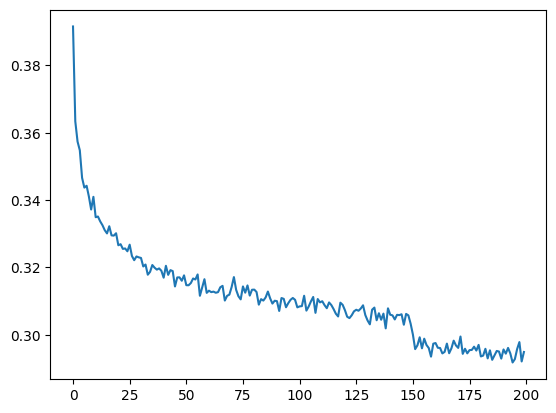

In [75]:
# notice we have to copy the tensor to the cpu
plt.plot(torch.tensor(lossi).cpu().view(-1, 1000).mean(dim=1))

In [76]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


#### Evaluate the Loss 2 (copied from a previous cell)

In [77]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    logits = model(x)
    # loss = F.cross_entropy(x, y)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.938451886177063
val 2.0253219604492188


#### Fixing BatchNorm1d bug

It turns out we did not spend a lot of time figuring out an optimal selection of parameters for our model, and we also may have a bug in our BatchNorm1d layer. 

In [78]:
# Total run time up to this point running on the CPU
# Run Date: Saturday, June 17, 2023
# Run Time: 00:22:28


# GPU run time up to this point ...
# Run Date: Saturday, June 17, 2023
# Run Time: 00:14:37
# Run Date: Saturday, June 17, 2023
# Run Time: 00:14:48

In [79]:
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim=True)
evar = e.var(0, keepdim=True)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
e.shape, emean.shape, evar.shape, ehat.shape

(torch.Size([32, 4, 68]),
 torch.Size([1, 4, 68]),
 torch.Size([1, 4, 68]),
 torch.Size([32, 4, 68]))

emean, and evar are calculated over the 32 numbers in the first dimension, producing a tensor of shape 1x4x68.

Looking at the documentatioin of [PyTorch Mean](https://pytorch.org/docs/stable/generated/torch.mean.html) you can see for the first parameter we can pass in a tuple of ints instead of just a single int.

In [80]:
e = torch.randn(32, 4, 68)
emean = e.mean((0,1), keepdim=True)
evar = e.var((0,1), keepdim=True)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
e.shape, emean.shape, evar.shape, ehat.shape

(torch.Size([32, 4, 68]),
 torch.Size([1, 1, 68]),
 torch.Size([1, 1, 68]),
 torch.Size([32, 4, 68]))

Looking above, we can see the shape of the output tensor, where we took the mean over both the 0th and 1st dimension, producing a tensor of shape 1x1x68.

So let's change the implementation of BatchNorm1d so that it can take 3 dimensional inputs.

In [81]:
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            # code changes START
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
            # code changes END
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

So let's reinitialize the network and train the new model.

In [82]:
n_embd = 10
n_hidden = 68

model = Sequential([

    Embedding(vocab_size, n_embd),
    
    FlattenConsecutive(2),  Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),

    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22397


#### Training Loop 4 (copied from a previous cell)

In [83]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # 1) minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # 2) Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # 3) backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # 4) update using simple stochastic gradient descent
    lr = 0.1 if i < 150000 else 0.01 # step learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # 5) track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

# GPU
# CPU times: user 5min 34s, sys: 1.73 s, total: 5min 36s
# Wall time: 5min 47s
# CPU times: user 5min 41s, sys: 1.92 s, total: 5min 43s
# Wall time: 5min 54s
# CPU times: user 5min 38s, sys: 1.78 s, total: 5min 40s
# Wall time: 5min 51s

      0/ 200000: 3.3755
  10000/ 200000: 1.9929
  20000/ 200000: 2.5975
  30000/ 200000: 2.1516
  40000/ 200000: 2.3928
  50000/ 200000: 2.2867
  60000/ 200000: 1.9662
  70000/ 200000: 2.3959
  80000/ 200000: 1.8539
  90000/ 200000: 2.2673
 100000/ 200000: 2.0198
 110000/ 200000: 2.3406
 120000/ 200000: 1.8734
 130000/ 200000: 1.7223
 140000/ 200000: 1.5937
 150000/ 200000: 1.7613
 160000/ 200000: 1.7226
 170000/ 200000: 1.7459
 180000/ 200000: 1.5664
 190000/ 200000: 2.0418
CPU times: user 5min 34s, sys: 1.73 s, total: 5min 36s
Wall time: 5min 47s


In [84]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


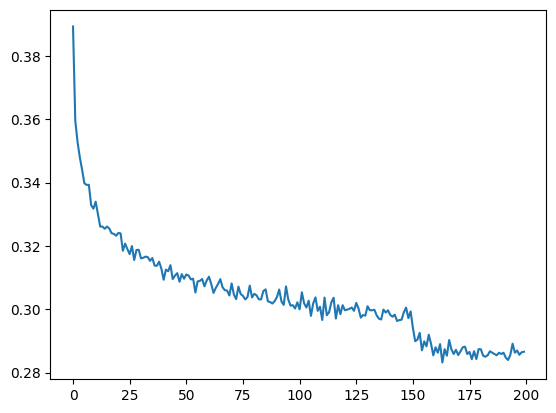

In [85]:
# notice we have to copy the tensor to the cpu
plt.plot(torch.tensor(lossi).cpu().view(-1, 1000).mean(dim=1))

#### Evaluate the loss 2 (copied from a previous cell)

In [86]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    logits = model(x)
    # loss = F.cross_entropy(x, y)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.9086217880249023
val 2.018139362335205


There has been a slight improvement to the validation loss.

Now let's again increase the size of the network to see what kind of performance gains can be acheived.

In [87]:
# Increase n_embd and n_hidden ...
# n_embd = 10
# n_hidden = 68
n_embd = 24
n_hidden = 128

model = Sequential([

    Embedding(vocab_size, n_embd),
    
    FlattenConsecutive(2),  Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),

    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

76579


Our parameter count went up from 22,397 parameters to 76,579.

#### Training Loop 4 (copied from a previous cell)

In [88]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # 1) minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # 2) Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # 3) backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # 4) update using simple stochastic gradient descent
    lr = 0.1 if i < 150000 else 0.01 # step learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # 5) track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

# GPU
# CPU times: user 5min 38s, sys: 1.79 s, total: 5min 40s
# Wall time: 5min 52s
# CPU times: user 5min 43s, sys: 1.79 s, total: 5min 45s
# Wall time: 5min 56s

      0/ 200000: 3.4472
  10000/ 200000: 2.2922
  20000/ 200000: 2.5601
  30000/ 200000: 2.2918
  40000/ 200000: 2.1732
  50000/ 200000: 2.3294
  60000/ 200000: 1.8983
  70000/ 200000: 1.8565
  80000/ 200000: 2.1898
  90000/ 200000: 2.0798
 100000/ 200000: 1.7897
 110000/ 200000: 1.6745
 120000/ 200000: 1.6447
 130000/ 200000: 1.8421
 140000/ 200000: 1.7779
 150000/ 200000: 2.0121
 160000/ 200000: 1.8392
 170000/ 200000: 1.4430
 180000/ 200000: 1.6880
 190000/ 200000: 1.7892
CPU times: user 5min 38s, sys: 1.79 s, total: 5min 40s
Wall time: 5min 52s


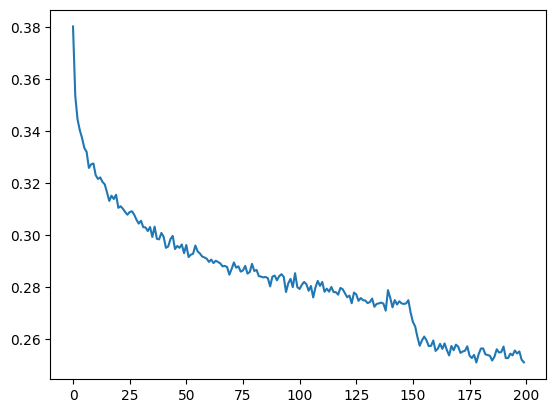

In [89]:
# notice we have to copy the tensor to the cpu
plt.plot(torch.tensor(lossi).cpu().view(-1, 1000).mean(dim=1))

#### Sample from the model 2 (copied from a previous cell)

In [90]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:

        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, then break
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # decode and print the generated word

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

#### Evaluate the loss 2 (copied from a previous cell)

In [91]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    logits = model(x)
    # loss = F.cross_entropy(x, y)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.7686147689819336
val 1.9898103475570679


The validation loss has decrease from 2.02 to 1.99. Nice!

In [92]:
# Total run time up to this point.
# GPU
# Run Date: Saturday, June 17, 2023
# Run Time: 00:26:44

#### Experimental harness

![](images/ResidualAndSkipConnections.png)

Our model did not implement this forward pass of the original WaveNet networks, where there are skip and residual connections.

In [93]:
endTime = time.time()

elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")

# Run Date: Saturday, June 17, 2023
# Run Time: 00:28:44
